# 토마토 꽃 데이터 학습을 위한 프로토 타입 코드 3

- 연습 버전
- 최종 목표는 이진 분류를 통해 3개화 이상의 화방과 2개화 이하의 화방을 분류하는것이 최종 목표
    - 더 궁극적으로는 개화 개수를 알면 더욱 좋다
    

- 현재 코드는 미개화군, 개화군 화방을 분류 해보는 이진 코드를 작성

- CNN 학습
- 학습 데이터의 특징
    - 약 1300개의 데이터를 통한 학습
    - 화방당 0~2개의 개화는 미개화군, 화방당 3개 이상의 개화는 개화군으로 분류 
    - 모든 개화수는 1화방당으로 정의 


### 데이터 준비

In [1]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [3]:
# 라벨링: 0 - 3개 미만 : 0, 1 - 3개 이상 : 1
class_dirs = {
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/unblossomed': 0,       # 미개화 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_1': 0,       # 개화 1개 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_2': 0,       # 개화 2개 디렉토리 경로
    'E:/tomato_data/TOMATO_BLOOMING_IMAGE_ENV_20231124/TOMATO_BLOOMING_IMAGE_ENV_20231124/blossomed_3/rotated': 1# 개화 3개 이상 디렉토리 경로
}

# 이진 분류하기 위해 0과1 작성
# 클래스별 파일 경로

In [4]:
# 이미지 파일 경로와 라벨 저장할 리스트
image_paths = []
labels = []



In [5]:
# 라벨은 클래스 번호로 지정 (0부터 시작)
for class_dir, label in class_dirs.items():
    paths = glob.glob(f'{class_dir}/*.jpg')     
    for path in paths:
        image_paths.append(path)
        labels.append(label)
        


In [6]:
# 이미지 로딩 및 전처리
# 모든 이미지가 너무 커서 전처리 작업 필요
# 원래 이미지가 거의 3000*4000의 픽셀을 가지기에 300*400으로 축소

images = np.array([img_to_array(load_img(img, target_size=(400, 300))) for img in image_paths])

# 라벨을 NumPy 배열로 변환
labels = np.array(labels)

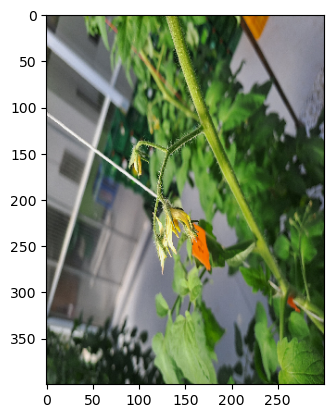

In [7]:
import matplotlib.pyplot as plt
# 1661번째 이미지 확인
img = images[1720]

# 이미지 확인
plt.imshow(img.astype(int))  # 이미지 데이터는 float 형태이므로 int로 변환
plt.show()

In [8]:
# train-test split
# test 사이즈는 0.2로 지정
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [9]:
# 클래스 가중치 계산
# 불균형한 클래스 분포를 가진 데이터셋에 대해 각 클래스의 가중치를 계산
# 이를 딕셔너리 형태로 제공하여 모델 학습에 사용할 수 있게 하는 코드
# 3개이상 개화 이미지가 적어 사용하는 코드

class_weights = compute_class_weight(
    # 'balanced' 옵션은 클래스 빈도의 역수로 가중치를 계산, 샘플 수가 적은 클래스의 가중치가 더 높아진다
    class_weight='balanced',
    
    # 고유한 클래스 레이블을 추출
    classes=np.unique(y_train),
    
    # 가중치를 계산할 때 사용할 대상 클래스 레이블을 제공
    y=y_train
)
# 계산된 클래스 가중치를 파이썬 딕셔너리 형태로 변환하는 코드
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
# 이 딕셔너리는 각 클래스 레이블을 키로, 해당 클래스의 가중치를 값으로 가짐
# 이 딕셔너리는 나중에 모델 학습 시 class_weight 매개변수로 사용될 수 있음


In [10]:
# CNN 모델 정의
model = Sequential([
    # 2차원 컨볼루션 레이어
    # 입력 이미지에 3x3 크기의 필터를 적용하고, 그 결과를 32개의 특징 맵으로 제작
    # activation 함수로는 'relu'를 사용
    # 렐루 : 입력이 0보다 크면 입력값을 그대로 반환하고, 0보다 작으면 0을 반환하는 간단한 함수
    
    # input_shape=(400, 300, 3)는 입력 이미지의 크기를 정의하는 부분
    # 400x300 크기의 RGB 이미지를 입력으로 받음
    Conv2D(32, (3, 3), activation='relu', input_shape=(400, 300, 3)),
    
    # axPooling2D((2, 2)) MaxPooling2D는 2D 풀링 레이어
    # 이 레이어는 2x2 크기의 윈도우를 이동시키면서 그 안에서 가장 큰 값만을 선택하는 방식으로 특징 맵의 크기를 축소
    MaxPooling2D((2, 2)),
    
    # 과적합을 방지하기 위한 레이어
    # 학습 과정에서 무작위로 노드의 50%를 비활성화시킵니다.
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    
    # 다차원의 텐서를 1차원으로 평탄화
    # 이 레이어를 통해 컨볼루션 레이어와 완전 연결 레이어를 연결할 수 있다
    Flatten(),
    
    # 출력 레이어
    # 이진 분류를 위해 1개의 노드를 가지며, activation 함수로는 'sigmoid'를 사용
    # sigmoid' 함수는 출력값을 0과 1 사이로 제한
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

In [11]:
# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 149, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 149, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 71, 64)        3

In [13]:
# 모델 학습
history = model.fit(
    x_train, 
    y_train, 
    class_weight=class_weight_dict, 
    epochs=50, 
    batch_size=64, 
    validation_data=(x_test, y_test)
)

Epoch 1/50
28/28 [==============================] - 120s 4s/step - loss: 90.7862 - accuracy: 0.5662 - val_loss: 0.6929 - val_accuracy: 0.8106
Epoch 2/50
28/28 [==============================] - 119s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6929 - val_accuracy: 0.8106
Epoch 3/50
28/28 [==============================] - 124s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6928 - val_accuracy: 0.8106
Epoch 4/50
28/28 [==============================] - 123s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6928 - val_accuracy: 0.8106
Epoch 5/50
28/28 [==============================] - 119s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6927 - val_accuracy: 0.8106
Epoch 6/50
28/28 [==============================] - 122s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6927 - val_accuracy: 0.8106
Epoch 7/50
28/28 [==============================] - 121s 4s/step - loss: 0.6931 - accuracy: 0.8323 - val_loss: 0.6926 - val_accuracy: 0.8106
Epoch 8/50
2

In [14]:
# 학습 과정에서의 손실과 정확도 그래프 작성
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

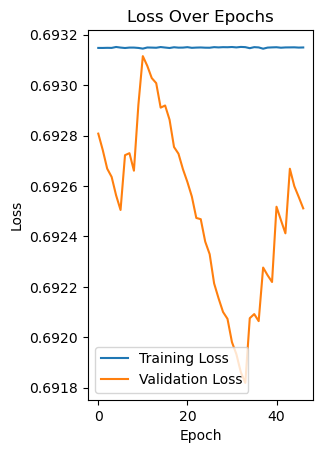

In [15]:
# 손실 그래프
plt.subplot(1, 2, 1)
# 첫 3개의 데이터 포인트를 제외하고 손실 데이터를 슬라이싱하여 플롯
plt.plot(history.history['loss'][3:], label='Training Loss')
plt.plot(history.history['val_loss'][3:], label='Validation Loss')

# 그래프의 나머지 부분 설정
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

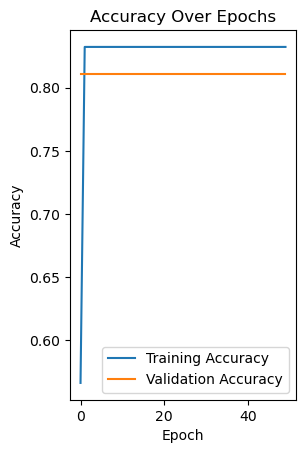

In [16]:
# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 [==============================] - 0s 80ms/step


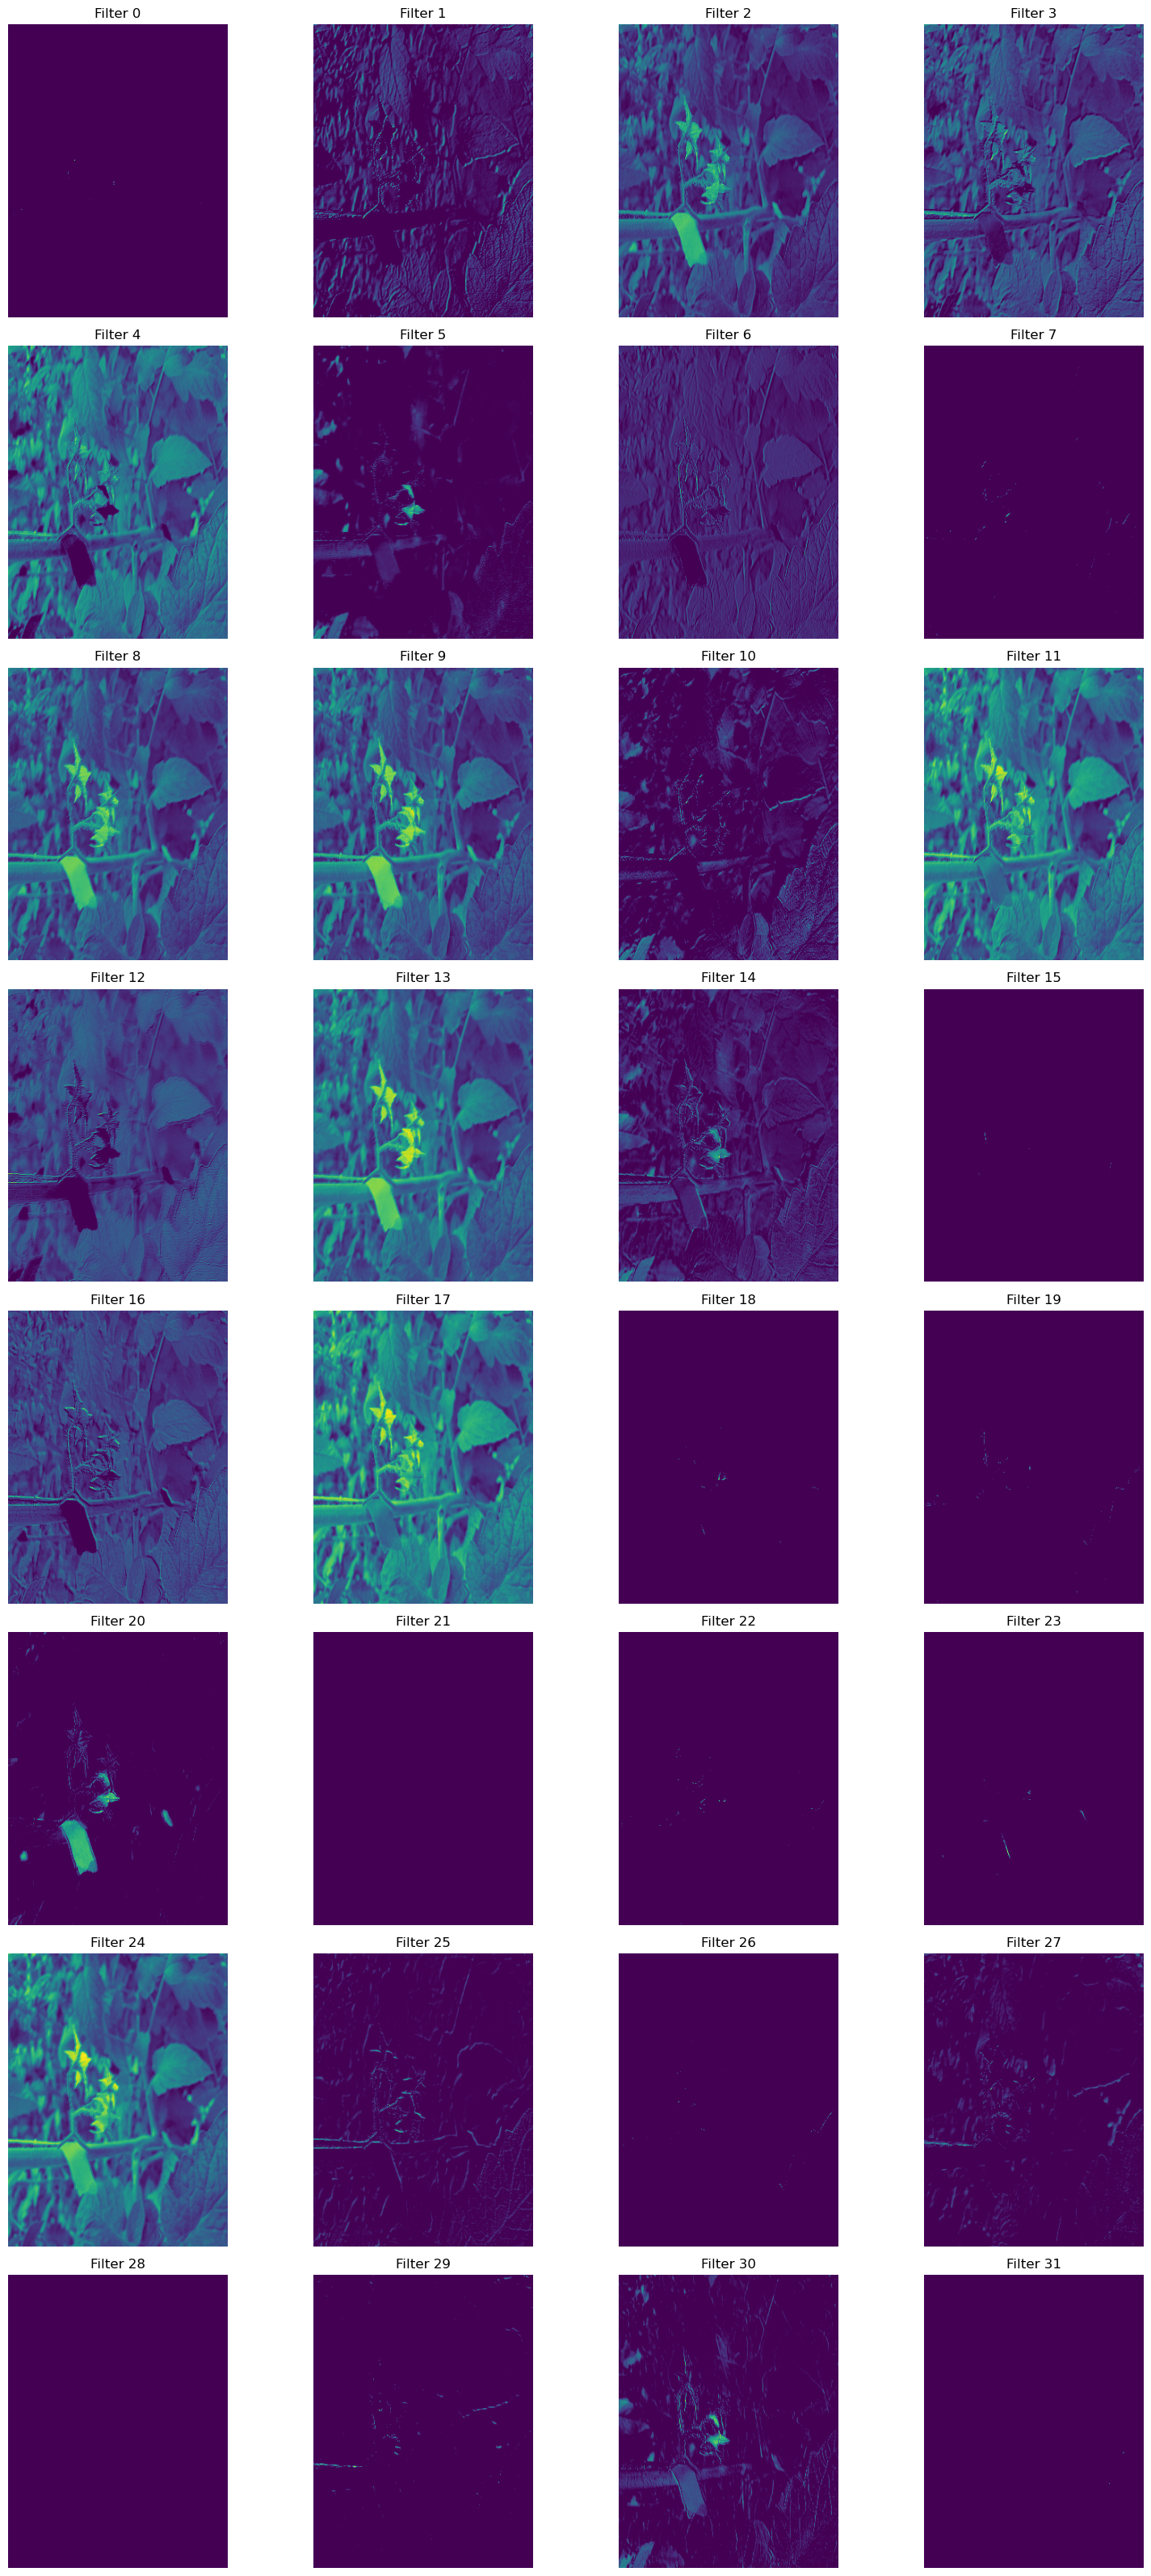

In [24]:
from keras import models
import matplotlib.pyplot as plt

# 활성화 맵을 시각화하는 함수 정의
def plot_activation_maps(activations, layer_index, num_rows=8, num_cols=4):
    layer_activation = activations[layer_index]
    num_features = layer_activation.shape[-1]
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axes = axes.flatten()

    for i in range(num_features):
        ax = axes[i]
        # 특성 맵의 i번째 채널을 추출
        feature_map = layer_activation[0, :, :, i]
        # 필터의 활성화를 시각화
        ax.imshow(feature_map, cmap='viridis')
        ax.set_title(f'Filter {i}')
        ax.axis('off')

    # 남은 서브플롯을 숨김
    for i in range(num_features, num_rows * num_cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 이미지 선택
selected_image = x_train[470]  # 이곳에 특성 맵을 보고 싶은 이미지의 인덱스를 입력
selected_image = np.expand_dims(selected_image, axis=0)

# 활성화 맵 계산
layer_outputs = [layer.output for layer in model.layers[:8]]  # 처음 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)  # 이 출력으로 모델을 생성
activations = activation_model.predict(selected_image)

# 활성화 맵 시각화
plot_activation_maps(activations, layer_index=0)  # 'layer_index'는 시각화하고 싶은 층의 인덱스


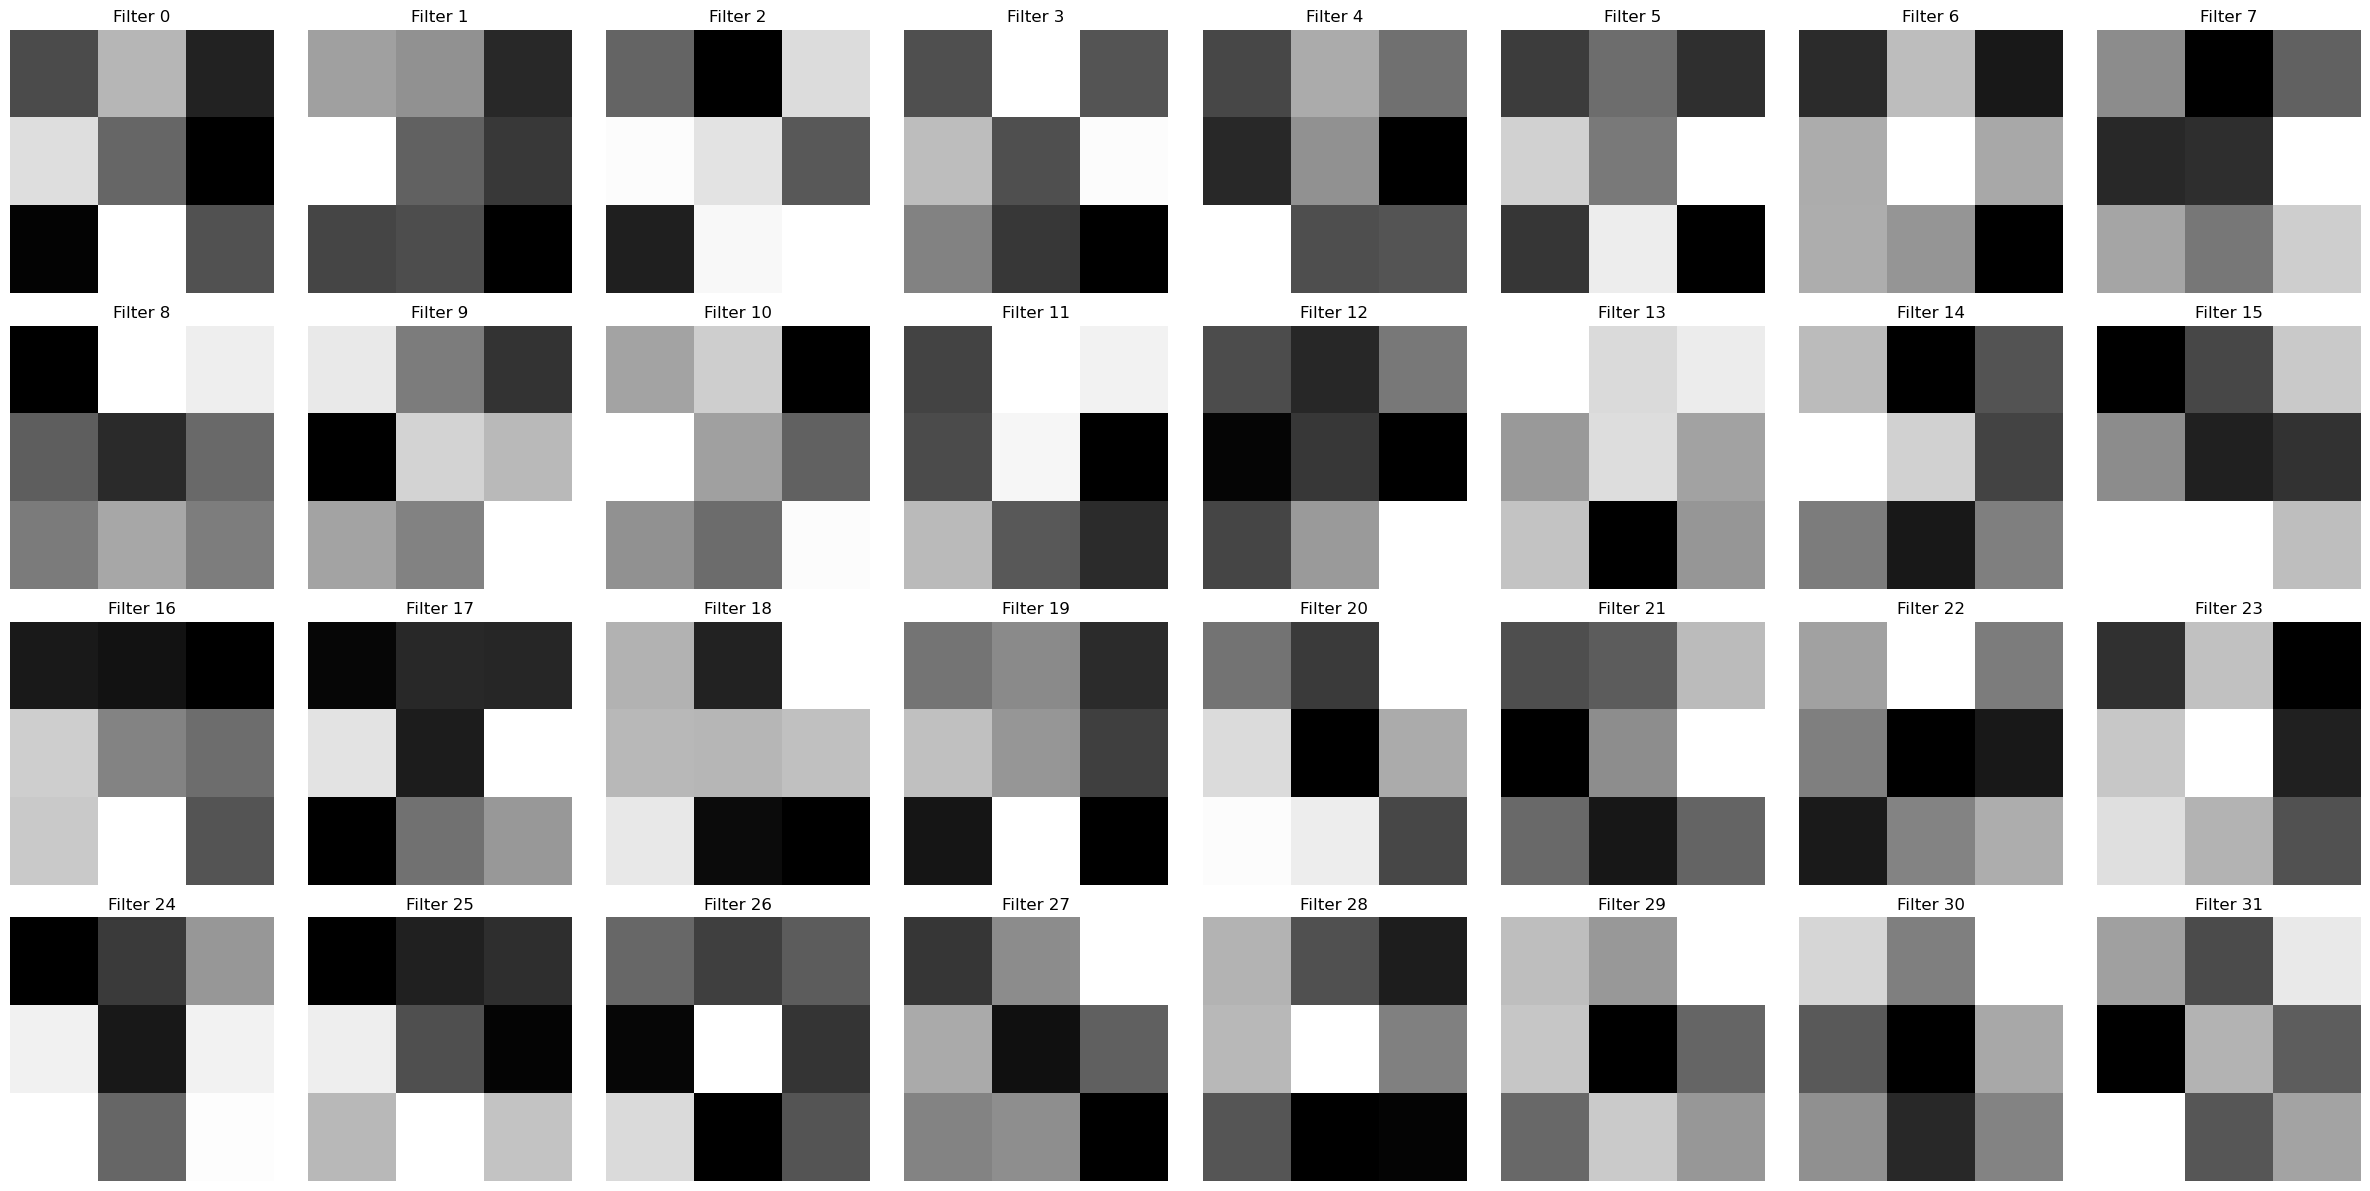

In [18]:
import matplotlib.pyplot as plt

# 첫 번째 합성곱 층의 가중치 가져오기
weights, biases = model.layers[0].get_weights()

# 가중치의 최대값과 최소값을 구해서 정규화에 사용
min_val, max_val = weights.min(), weights.max()

# 첫 번째 층의 출력 채널 수 만큼 반복
n_filters = weights.shape[-1]
n_cols = 8  # 열의 수
n_rows = 4  # 행의 수

plt.figure(figsize=(n_cols * 3, n_rows * 3))

for i in range(n_filters):
    # 각 필터의 첫 채널만 시각화 (필터의 채널이 여러 개인 경우 평균을 낼 수도 있음)
    filter = weights[:, :, 0, i]
    
    # i + 1 번째의 subplot을 생성 (subplot 인덱스는 1부터 시작)
    plt.subplot(n_rows, n_cols, i + 1)
    # 정규화를 통해 픽셀 값의 범위를 0과 1 사이로 조정
    plt.imshow((filter - min_val) / (max_val - min_val), cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')  # 축을 표시하지 않음

plt.tight_layout()
plt.show()

### 2024.01.13 일 코드 간단 총평
- 이진 분류 코드 결과가 정확도 0.83정도로 올라 생각보다 더 높은 수치를 기록하여 만족스러운편
- 하지만 손실값이 너무 높아서 좀더 좋은 하이퍼파라미터와 이미지 데이터를 제공하도록 노력해야함
- 3개화 이상의 화방이 비율이 상대적으로 너무 적어서 수를 더 찾아야한다
- 몇가지 코드구조를 수정해야하고 좀더 내용을 공부할 필요가 무조건적으로 있음
- 특성맵을 살펴보니 그래도 꽤 괜찮은 방향성으로 학습하고 있는거같음